# Imports



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import numpy as np
from sklearn.pipeline import *
from sklearn import *
from sklearn.model_selection import *
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from nltk import tokenize
import itertools
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud

language = 'english'
true = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv")

## Nettoyage des données





Ajout d'une colonne pour différentier

In [2]:
true['etat'] = 'true'
fake['etat'] = 'false'
dataset = pd.concat([true,fake]).reset_index(drop = True)
dataset.drop(["date"],inplace = True,axis=1)
dataset.drop(["title"],inplace = True,axis=1)
dataset = shuffle(dataset)
dataset.reset_index(drop = True)
dataset.head()

,text,subject,etat
32511,"Yes, the Democrats think it s a good thing to ...",politics,false
22738,"A comedian went too far today and for that, sh...",News,false
3947,WASHINGTON (Reuters) - The U.S. National Secur...,politicsNews,true
9345,CHICAGO (Reuters) - Chicago will be able to sp...,politicsNews,true
40495,Dozens of supporters of US President Donald Tr...,left-news,false


on separe les mots et retire la ponctuation

In [3]:
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
dataset["text"] = dataset["text"].str.replace('[^\w\s]','')
dataset.head()


,text,subject,etat
32511,yes the democrats think it s a good thing to r...,politics,false
22738,a comedian went too far today and for that she...,News,false
3947,washington reuters the us national security a...,politicsNews,true
9345,chicago reuters chicago will be able to sprea...,politicsNews,true
40495,dozens of supporters of us president donald tr...,left-news,false


In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words(language))

dataset['text'] = dataset['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /Users/gosow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
dataset.head()


,text,subject,etat
32511,yes democrats think good thing repeat foul com...,politics,false
22738,comedian went far today apologized outrage ens...,News,false
3947,washington reuters us national security agency...,politicsNews,true
9345,chicago reuters chicago able spread statemanda...,politicsNews,true
40495,dozens supporters us president donald trump ra...,left-news,false


# Representation des données

Repartitions

etat
false    23481
true     21417
Name: text, dtype: int64


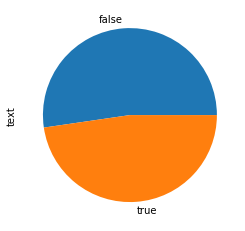

In [6]:
#nombre de vrai et faux
representation = dataset.groupby(['etat'])['text'].count()
representation.plot.pie()
print(representation)

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


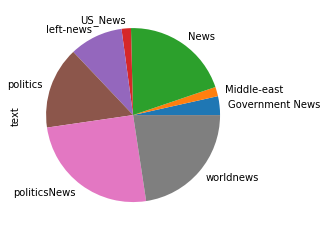

In [7]:
representation = dataset.groupby(['subject'])['text'].count()
representation.plot.pie()

print(representation)



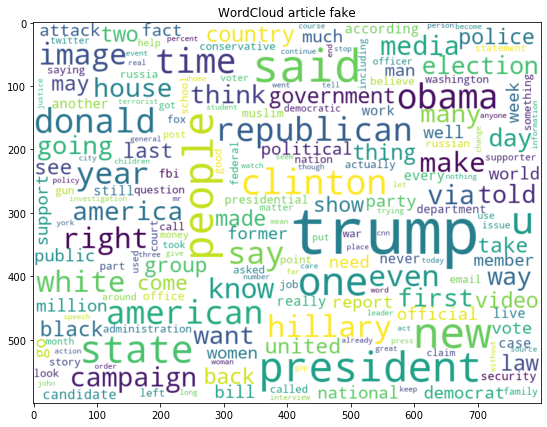

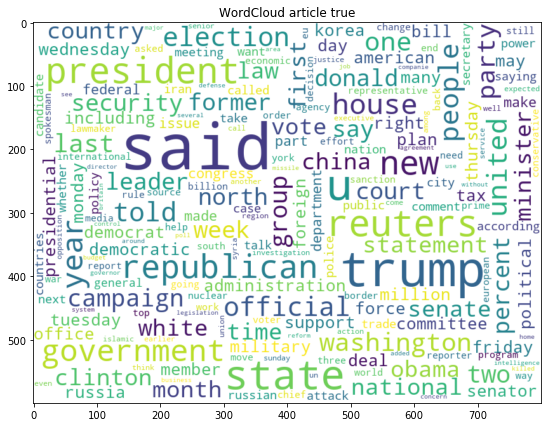

In [8]:
def clouding(data,etat,title):
    cloud= data[data["etat"] == etat]
    words = ' '.join([text for text in cloud.text])
    wordcloud = WordCloud(height= 600,max_font_size = 100,collocations = False,width= 800,background_color="White").generate(words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.show()

clouding(dataset,'false',"WordCloud article fake")
clouding(dataset,'true',"WordCloud article true")

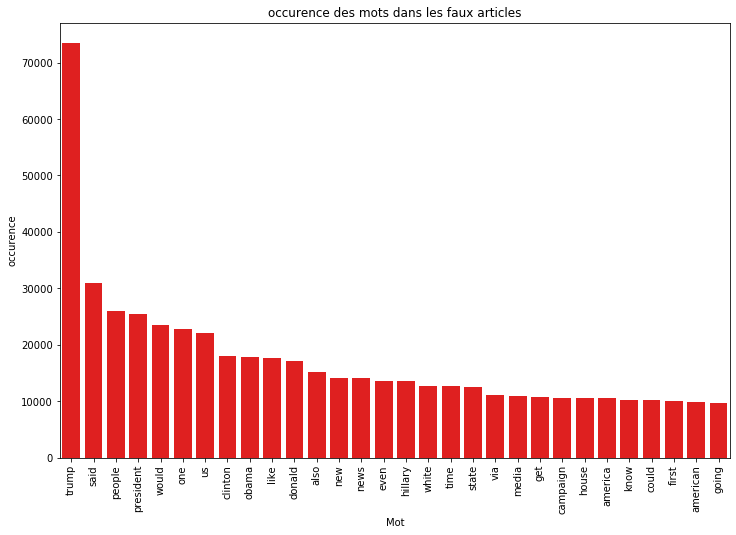

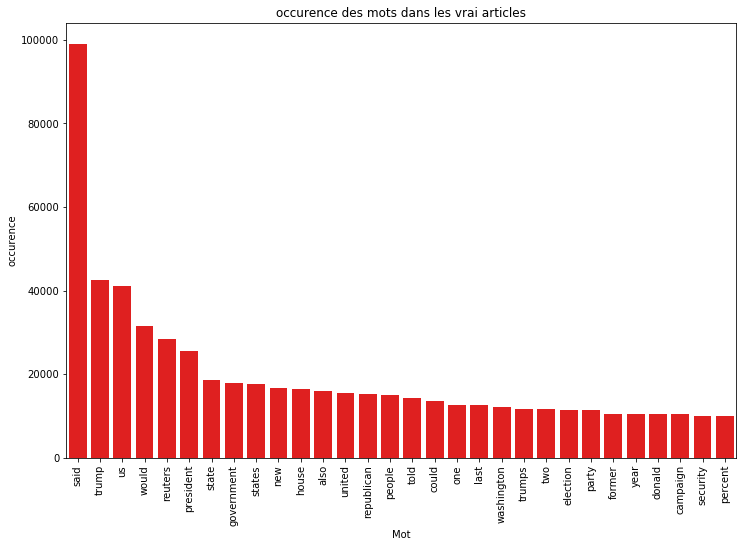

In [9]:
token = tokenize.WhitespaceTokenizer() # separe le text en mots
def counter(typeoftoken,text, column_text, quantity,title):
    words = ' '.join([text for text in text[column_text]])
    phrase = token.tokenize(words)
    frequence = nltk.FreqDist(phrase)
    dataframe_frequence = pd.DataFrame({"Mot": list(frequence.keys()),"Frequence": list(frequence.values())})
    dataframe_frequence = dataframe_frequence.nlargest(columns = "Frequence", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = dataframe_frequence, x = "Mot", y = "Frequence", color = 'Red')
    ax.set(ylabel = "occurence")
    plt.title(title)
    plt.xticks(rotation='vertical')
    plt.show()
counter(token,dataset[dataset["etat"] == "false"], "text", 30,"occurence des mots dans les faux articles")
counter(token,dataset[dataset["etat"] == "true"], "text", 30,"occurence des mots dans les vrai articles")

# Splitting


In [10]:
train_x,test_x,train_y,test_y = train_test_split(dataset['text'], dataset["etat"], test_size=0.25,random_state = 0)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(33673,) (11225,) (33673,) (11225,)


In [11]:
pline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

In [12]:
model_LogR = pline.fit(train_x, train_y)

In [14]:
testing_pred = model_LogR.predict(test_x)
print("% de reussite :")
print(round(accuracy_score(test_y, testing_pred)*100,2))
print(train_x.shape,  test_x.shape)
#print( model_LogR.predict([""] ))


% de reussite :
98.78
(33673,) (11225,)


In [1]:
import pickle as pickle

In [20]:
pickle.dump(model_LogR,open("./Faker_serialized.pkl","wb+"))

In [2]:

model = pickle.load(open("./Faker_serialized.pkl","rb"))
print((model.predict_proba([""])))


[[7.04017160e-04 9.99295983e-01]]
